# feature selection-feature engineering

## Goal

The aim of this notebook is to identify and isolate the most informative set of predictors for modeling apartment sale prices, ensuring we build a lean yet powerful regression pipeline. To achieve this, we:

1. **Explore quantitative features** via correlation analysis to remove multicollinearity and redundant variables.
2. **Assess categorical predictors** for association with price and retain only those adding genuine signal.
3. **Engineer and scale features**, then compare a “core” subset against the full set in an ablation experiment.
4. **Investigate outcome transformations** (log and Box–Cox) to find the best way to normalize the target without sacrificing real-world forecast accuracy.

By the end, we want a minimal feature set and transformation strategy that deliver robust, interpretable, and accurate price predictions.


In [36]:
import pickle
import pandas as pd

with open("/Users/majid/Documents/second semester/machine learning /_assessment_project/apartment_prepared.pkl", "rb") as f:
    df      = pickle.load(f)   # reload train set
    df_test = pickle.load(f)   # reload test set

# Quick check
print(df.shape, df_test.shape)


(156454, 62) (39114, 62)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from scipy.stats import boxcox, yeojohnson # for power transformations


## **Quantitative** explanatory variables - correlations

In [ ]:
# lets store the list of names of quantitative (numeric) variables into a vector
df_numeric_columns = df.select_dtypes(include=[np.number]).columns
print(df_numeric_columns)

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_pharma', 'price_z', 'market_volatility',
       'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index',
       'green_space_ratio', 'estimated_maintenance_cost',
       'global_economic_index', 'cond_class_53cced8d', 'cond_class_a2881958',
       'cond_class_unknown_cond_class', 'cond_class_nan', 'obj_type_0d6c4dfc',
       'obj_type_2a6d5c01', 'obj_type_unknown_obj_type', 'own_type_Other',
       'own_type_bfb8fe10', 'build_mat_7f8c00f9',
       'build_mat_unknown_build_mat', 'has_park_1', 'has_balcony_1',
       'has_lift_1', 'has_sec_1', 'has_store_1', 'src_month_2', 'src_month_3',
       'src_month_4', 'src_month_5', 'src_month_6', 'src_month_8',
       'src_month_9', 'src_month_10', 'src_month_11', 'src_month_12',
       'loc_code_143768f7', 'loc_code_378f340c', 'loc_code_3cb4aaff',
       

In [39]:
# Drop the target and the ID(it doesnt make sense)
feature_cols = [
    c for c in df_numeric_columns 
    if c not in ("unit_id", "price_z")
]


print("Predictor columns:", feature_cols)

Predictor columns: ['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma', 'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio', 'estimated_maintenance_cost', 'global_economic_index', 'cond_class_53cced8d', 'cond_class_a2881958', 'cond_class_unknown_cond_class', 'cond_class_nan', 'obj_type_0d6c4dfc', 'obj_type_2a6d5c01', 'obj_type_unknown_obj_type', 'own_type_Other', 'own_type_bfb8fe10', 'build_mat_7f8c00f9', 'build_mat_unknown_build_mat', 'has_park_1', 'has_balcony_1', 'has_lift_1', 'has_sec_1', 'has_store_1', 'src_month_2', 'src_month_3', 'src_month_4', 'src_month_5', 'src_month_6', 'src_month_8', 'src_month_9', 'src_month_10', 'src_month_11', 'src_month_12', 'loc_code_143768f7', 'loc_code_378f340c', 'loc_code_3cb4aaff', 'loc_code_533f6886', 'loc_code_570cb745', 'loc_code_64a58667', 'loc_code_6900ba06', 'loc_code_69

### Mutually correlated (irrelevant) variables

In [ ]:
# Compute correlation matrix, handling missing data (NaN)
df_correlations = df[df_numeric_columns].corr(method = 'pearson')

print(df_correlations)

                     dim_m2   n_rooms  floor_no  floor_max  year_built  \
dim_m2             1.000000  0.763365 -0.065328  -0.122403   -0.018440   
n_rooms            0.763365  1.000000 -0.032792  -0.077753   -0.000217   
floor_no          -0.065328 -0.032792  1.000000   0.690259    0.057666   
floor_max         -0.122403 -0.077753  0.690259   1.000000    0.111501   
year_built        -0.018440 -0.000217  0.057666   0.111501    1.000000   
...                     ...       ...       ...        ...         ...   
loc_code_81b10147 -0.031224 -0.036175 -0.017138  -0.032174    0.014069   
loc_code_8d5a4f0c -0.054688 -0.062937 -0.013094  -0.018672   -0.061319   
loc_code_a6d54bd1  0.020920  0.014501 -0.000017  -0.002829   -0.018714   
loc_code_e0cff11b  0.004698  0.017050 -0.028823  -0.028864    0.045741   
loc_code_ece39f3d  0.013523  0.013532  0.017610   0.038228   -0.027674   

                   dist_centre     n_poi  dist_sch  dist_clinic  dist_post  \
dim_m2                0.042232  0

### Correlation plot:

<Axes: >

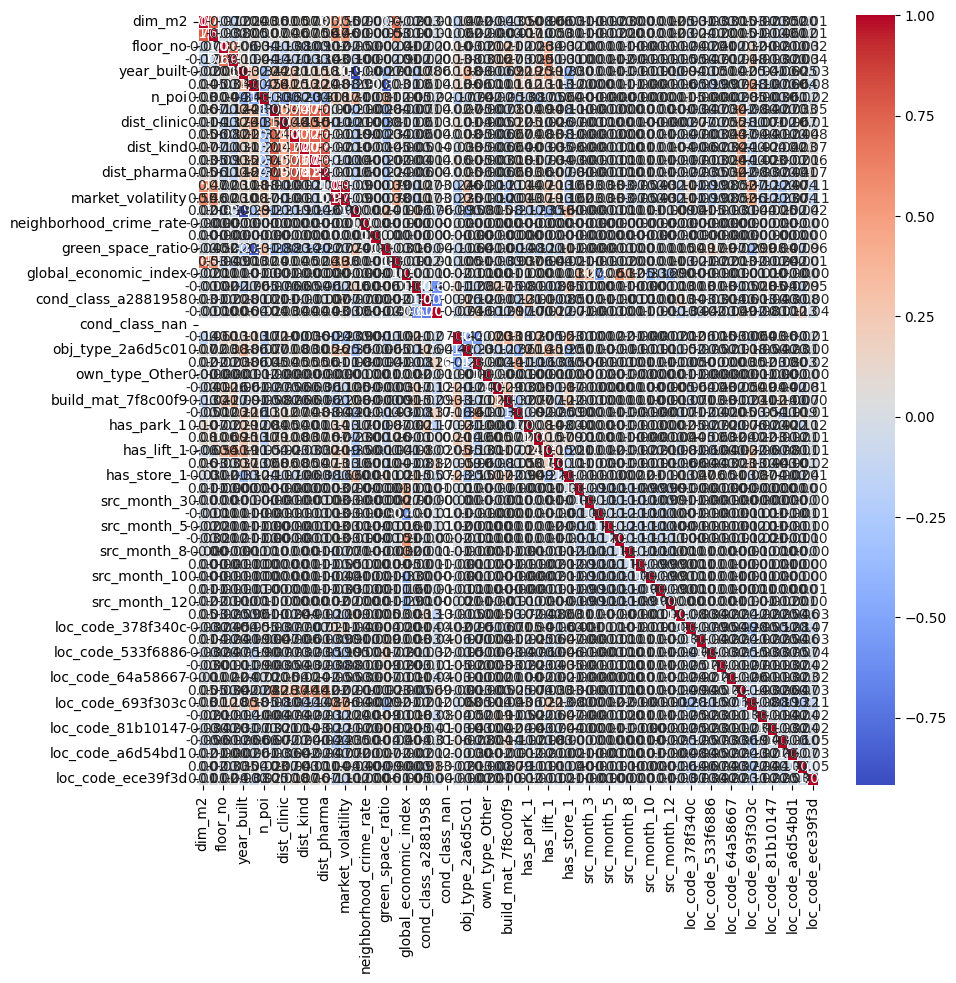

In [ ]:
# It is better to look at graphical representation of correlation matrix
plt.figure(figsize=(10, 10))

sns.heatmap(df_correlations,
            annot = True,
            cmap = "coolwarm",
            fmt = ".2f",
            linewidths = 0.5)

### lets mask the upper triangle for better visualizing relationships:

<Axes: >

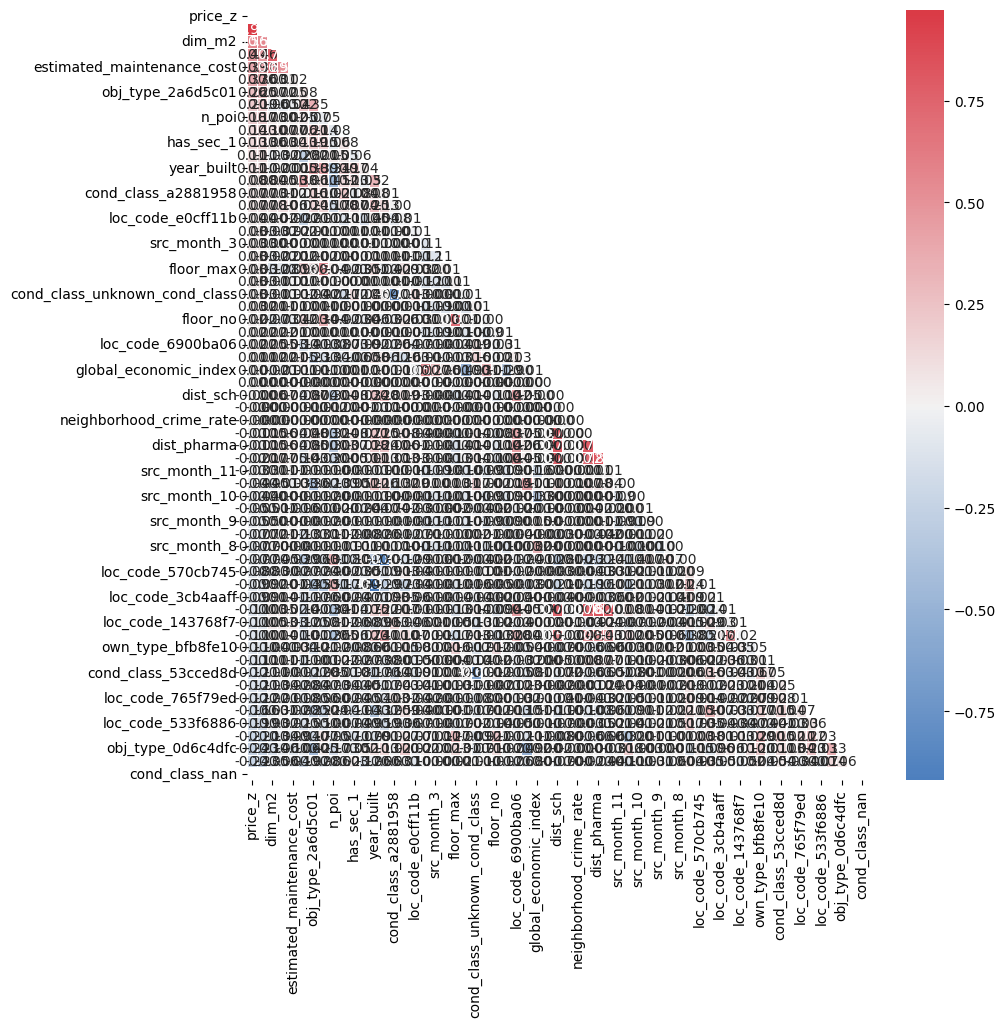

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_correlations, dtype = bool))
# Get the correlation of all features with 'price_z' and sort by the values
correlation_with_price = df_correlations['price_z'].sort_values(ascending = False)
ordered_columns = correlation_with_price.index  # This is the order of columns based on correlation
# Reorder the correlation matrix based on this order
df_correlations = df_correlations[ordered_columns].loc[ordered_columns]
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
# Create the heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(df_correlations,
            annot = True,
            cmap = my_cmap,
            mask = mask,
            fmt = ".2f",
            linewidths = 0.5,
            # this argument ensures that the color map is centered at 0,
            # meaning 0 will be displayed in white
            center = 0)

<Axes: >

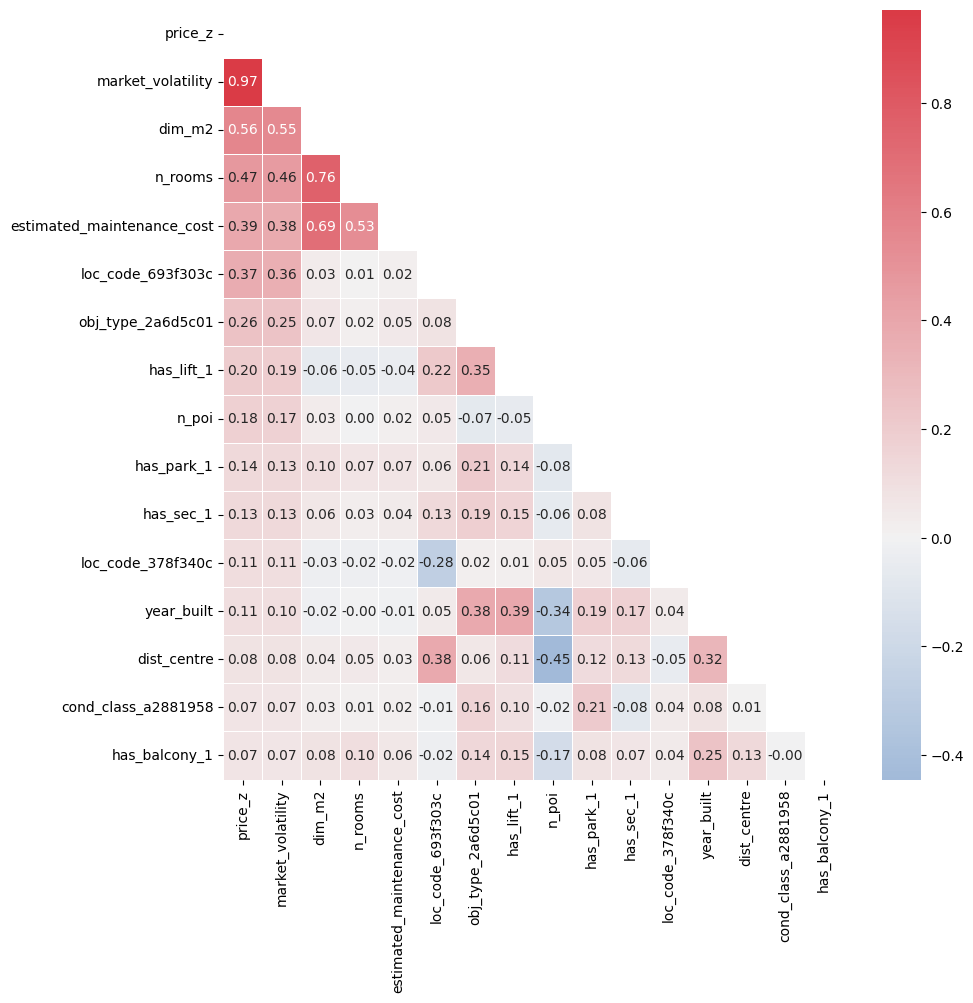

In [ ]:
# lets focus on the first 15 variables most correlated with price_z

# Create the heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(df_correlations.iloc[:16, :16],
            # 16 as we have empty row for Sale_Price on top
            annot = True,
            cmap = my_cmap,
            # remember to limit also the mask!
            mask = mask[:16, :16],
            fmt = ".2f",
            linewidths = 0.5,
            # this argument ensures that the color map is centered at 0,
            # meaning 0 will be displayed in white
            center = 0)

### 🔍 What I’m Seeing Before Feature Engineering

1. **Top raw drivers of price**

   * **market\_volatility (ρ ≈ 0.97)**: by far the strongest signal.
   * **dim\_m2 (ρ ≈ 0.56)** and **n\_rooms (ρ ≈ 0.47)**: bigger flats and more rooms matter a lot.
   * **estimated\_maintenance\_cost (ρ ≈ 0.39)**: higher upkeep bills go with pricier apartments.

2. **Location & type effects**

   * **loc\_code\_693f303c (ρ ≈ 0.37)**: this particular area code carries a big premium.
   * **obj\_type\_2a6d5c01 (ρ ≈ 0.26)**: one object-type category outperforms the rest.

3. **Key amenities**

   * **has\_lift\_1 (ρ ≈ 0.20)**: elevators add value.
   * **n\_poi (ρ ≈ 0.18)**, **has\_park\_1 (ρ ≈ 0.14)**, **has\_sec\_1 (ρ ≈ 0.13)**: proximity to shops, green spaces, and security features give modest boosts.
   * **has\_balcony\_1 (ρ ≈ 0.07)**: balconies help, but less so.

4. **Other modest signals**

   * **year\_built (ρ ≈ –0.11)**: newer buildings are slightly pricier.
   * **dist\_centre (ρ ≈ –0.08)**: being closer to the center helps, but not a huge effect once others are in.
   * **cond\_class\_a2881958 (ρ ≈ 0.07)**: one condition-class level edges out the rest.

5. **Warning: multicollinearity**

   * **dim\_m2 ↔ estimated\_maintenance\_cost (ρ ≈ 0.69)** and **estimated\_maintenance\_cost ↔ n\_rooms (ρ ≈ 0.53)** show these raw features share a lot of information.
   * Several location dummies also correlate with each other and with `year_built`.

---

💡 **Bottom line:** Before any engineering, most of the “signal” lives in **market\_volatility**, **flat size/rooms**, and **maintenance cost**, with a handful of location/type dummies and amenities trailing behind. But many of these raw columns overlap heavily—so pruning or combining them is crucial to avoid redundancy and overfitting.


In [44]:
# lets create a list of SELECTED numerical predictors:
# 15 with the highest Pearson correlation with the Price
top15 = correlation_with_price.index[1:16].tolist()  # skip the first entry ('price_z')


In [45]:
# also we should exclude 2 highly correlated variables n_room and estimated_maintenance_cost
for col in ['n_rooms', 'estimated_maintenance_cost']:
    if col in top15:
        top15.remove(col)
print("Reduced top features:", top15)


Reduced top features: ['market_volatility', 'dim_m2', 'loc_code_693f303c', 'obj_type_2a6d5c01', 'has_lift_1', 'n_poi', 'has_park_1', 'has_sec_1', 'loc_code_378f340c', 'year_built', 'dist_centre', 'cond_class_a2881958', 'has_balcony_1']


## Qualitative (categorical) variables

In [46]:
# lets create a list of names of categorical variables
df_categorical_variables = df.select_dtypes("object").columns

print(df_categorical_variables)

Index(['unit_id'], dtype='object')


In [47]:
df.drop(columns=['unit_id'],    inplace=True)
df_test.drop(columns=['unit_id'], inplace=True)


## Feature engineering 

I niticed I can change some varibles (for example by merging some of them to one variable or deviding them) to increase the correlation of variables with taget varibles (price_z)

In [48]:
# berfore doing that I again check my dataset to see if everithing is ok to continue:
# 3. Column dtypes & non-null counts
print(df.info())

# 4. Missing values per column (should all be zero)
print(df.isnull().sum())

# 5. Descriptive stats for numeric columns
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156454 entries, 0 to 156453
Data columns (total 61 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dim_m2                         156454 non-null  float64
 1   n_rooms                        156454 non-null  float64
 2   floor_no                       156454 non-null  float64
 3   floor_max                      156454 non-null  float64
 4   year_built                     156454 non-null  float64
 5   dist_centre                    156454 non-null  float64
 6   n_poi                          156454 non-null  float64
 7   dist_sch                       156324 non-null  float64
 8   dist_clinic                    156454 non-null  float64
 9   dist_post                      156266 non-null  float64
 10  dist_kind                      156291 non-null  float64
 11  dist_rest                      156063 non-null  float64
 12  dist_pharma                   

**near zero variance** :I saw there are some boolian variables which majority of it is 0(con_class) so they most probabbly do not add any information.
i will use a loop to remove this kind of varibales 

In [49]:
# Identify and drop NZV (near-zero-variance) dummies
# Threshold = mean < 0.005 (i.e. present in fewer than 0.5% of observations)
nzv = [c for c in df.columns 
       if (df[c].dtype in [int, bool] and df[c].mean() < 0.005)]
print("Dropping these NZV columns:", nzv)

df.drop(columns=nzv,      inplace=True)
df_test.drop(columns=nzv, inplace=True)


Dropping these NZV columns: []


 ## Feature Engineering
 ### merging features and scaling them

In [50]:
# Building age
# Instead of the raw year_built, use how old the building is today:
# Assuming your data is from 2024
df['building_age']      = 2024 - df['year_built']
df_test['building_age'] = 2024 - df_test['year_built']


In [51]:
# Floor ratio
# Relative height in the building:
df['floor_ratio']      = df['floor_no'] / df['floor_max']
df_test['floor_ratio'] = df_test['floor_no'] / df_test['floor_max']
# Since A 5th floor in a 5-story vs 30-story building is very different!

In [52]:
# Maintenance per square meter
# Normalize your cost estimate by size:
df['maint_cost_per_m2']      = df['estimated_maintenance_cost'] / df['dim_m2']
df_test['maint_cost_per_m2'] = df_test['estimated_maintenance_cost'] / df_test['dim_m2']


In [53]:
# Average distance to amenities
# instead of this many variables meerge it in one 
dist_cols = [
  'dist_sch','dist_clinic','dist_post','dist_kind',
  'dist_rest','dist_pharma'
]
df['avg_dist_amenities']      = df[dist_cols].mean(axis=1)
df['min_dist_amenities']      = df[dist_cols].min(axis=1)
df_test['avg_dist_amenities'] = df_test[dist_cols].mean(axis=1)
df_test['min_dist_amenities'] = df_test[dist_cols].min(axis=1)



In [ ]:
# Amenities count
# Count of perks : Sum up booleans into one “amenities_count".
# since The total number of perks might matter more than each individually.
perks = ['has_park_1','has_balcony_1','has_lift_1','has_sec_1','has_store_1']
df['amenities_count']      = df[perks].sum(axis=1)
df_test['amenities_count'] = df_test[perks].sum(axis=1)


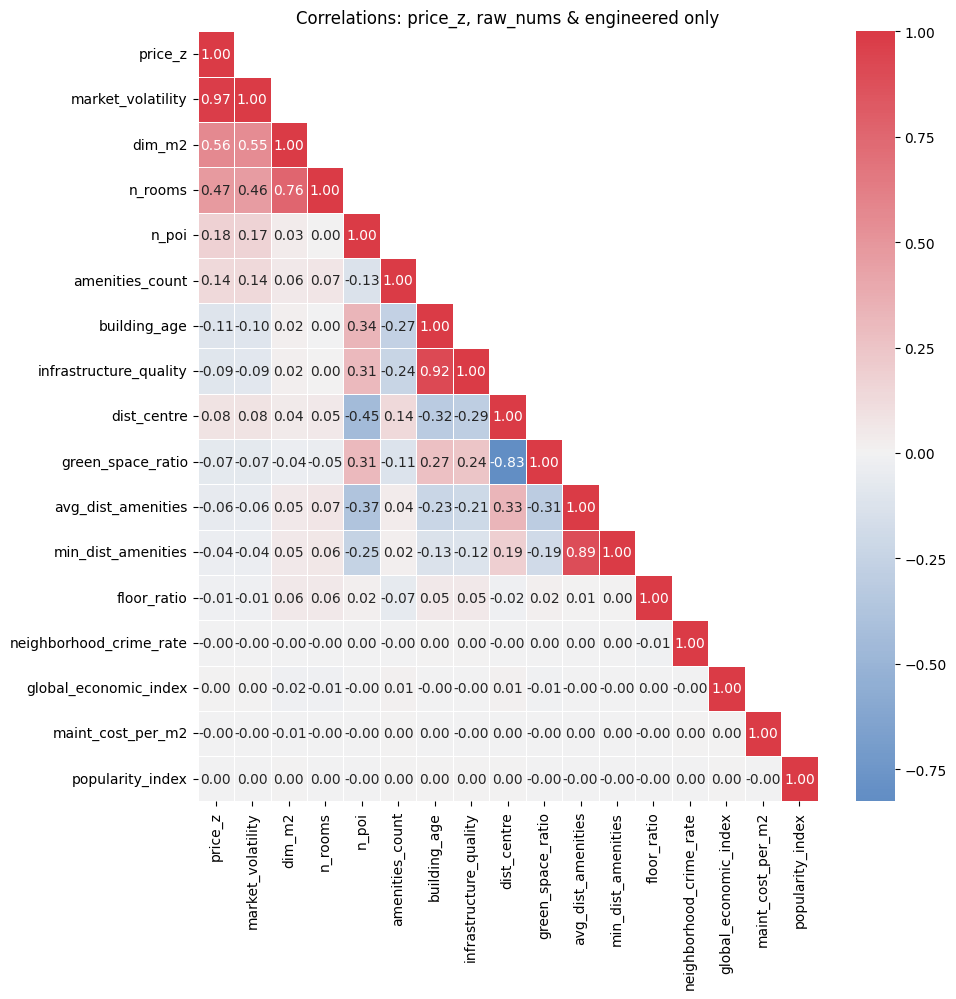

In [ ]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

# 1) reduced candidate list (no raw dist_*, no has_*, only raw_nums + engineered)
raw_nums = [
    'dim_m2','n_rooms','dist_centre','n_poi',
    'green_space_ratio','market_volatility',
    'infrastructure_quality','neighborhood_crime_rate',
    'popularity_index','global_economic_index'
]
engineered = [
    'building_age','floor_ratio',
    'avg_dist_amenities','min_dist_amenities',
    'maint_cost_per_m2','amenities_count'
]
candidates = raw_nums + engineered

# 2) Build the **new** corr matrix just on these + the target
corr_matrix = df[candidates + ['price_z']].corr()

# 3) Build the ordering: target first, then the rest by |ρ|
corr_with_target = corr_matrix['price_z'].abs().drop('price_z')
order = ['price_z'] + corr_with_target.sort_values(ascending=False).index.tolist()

# 4) Reorder the new matrix
corr_matrix = corr_matrix.loc[order, order]

# 5) Mask & plot
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
cmap = sns.diverging_palette(250, 10, as_cmap=True)

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlations: price_z, raw_nums & engineered only")
plt.show()


### 🔍 What the Correlation Heatmap Shows

1. **Strongest Predictors of Price**

   * **market\_volatility** (|ρ| ≈ 0.97): by far the dominant driver of apartment prices.
   * **dim\_m2** (|ρ| ≈ 0.56) and **n\_rooms** (|ρ| ≈ 0.47): bigger flats and more rooms also matter, but much less than market swings.

2. **Mid-Level Signals**

   * **n\_poi** (|ρ| ≈ 0.18): more nearby points of interest adds a modest premium.
   * **building\_age** (ρ ≈ –0.11): older buildings tend to be slightly cheaper.

3. **Weak or Negligible Effects**

   * **dist\_centre** (ρ ≈ –0.08): once everything else is in, distance to center barely moves the needle.
   * **green\_space\_ratio**, **infrastructure\_quality**, **neighborhood\_crime\_rate**, **popularity\_index**, **global\_economic\_index**, **floor\_ratio**, **avg\_dist\_amenities**, **min\_dist\_amenities**, **maint\_cost\_per\_m2**, **amenities\_count** all show |ρ| < 0.1—essentially noise after you’ve controlled for the top features.

4. **Engineered vs. Raw**

   * Some engineered features are highly inter-correlated (e.g. **avg\_dist\_amenities** vs. **min\_dist\_amenities**, **ρ** ≈ 0.89), so only one is needed.
   * **infrastructure\_quality** and **building\_age** correlate strongly with each other (ρ ≈ 0.92), but both remain weakly linked to price.

---

💡 **Bottom Line:**
The heatmap confirms that, among all raw and engineered candidates, **market\_volatility**, **dim\_m2**, and **n\_rooms** are the only really impactful predictors of price\_z. All others can safely be dropped or down-weighted without sacrificing much explanatory power.


### droping multicalinearity again

In [ ]:
# also we should exclude 2 highly correlated variables infrastructure_quality and min_dist_amenities
for col in ['infrastructure_quality', 'min_dist_amenities']:
    if col in candidates:
        candidates.remove(col)
print("clean features:", candidates)


clean features: ['dim_m2', 'n_rooms', 'dist_centre', 'n_poi', 'green_space_ratio', 'market_volatility', 'neighborhood_crime_rate', 'popularity_index', 'global_economic_index', 'building_age', 'floor_ratio', 'avg_dist_amenities', 'maint_cost_per_m2', 'amenities_count']


## Split the validation and train dataset 
Record counts are fairly balanced from Aug 2023 through Jun 2024 (all between ~12k–17k).
Average price shows a steady rise from ~690 k in Aug 23 to ~830 k in Mar 24, then plateaus around 825 k.


In [ ]:
# 1. Reload raw with datetime
raw = pd.read_csv("/Users/majid/Documents/second semester/machine learning /_assessment_project/data/appartments_train.csv")
raw['src_month_dt'] = pd.to_datetime(raw['src_month'] + "-01")

# 2. Re-attach unit_id to your prepped DataFrame
df["unit_id"] = raw["unit_id"].values

# 3. Now you can split by ID:
cutoff = pd.to_datetime("2024-03-31")
train_ids = set(raw.loc[raw["src_month_dt"] <= cutoff, "unit_id"])
val_ids   = set(raw.loc[raw["src_month_dt"]  > cutoff, "unit_id"])

# 4. Slice prepped df (which now has unit_id again)
X = df[candidates + ["unit_id"]]          # clean_feats = your selected predictors
y = df["price_z"]

X_train = X[X["unit_id"].isin(train_ids)].drop(columns="unit_id")
y_train = y[X["unit_id"].isin(train_ids)]

X_val   = X[X["unit_id"].isin(val_ids)].drop(columns="unit_id")
y_val   = y[X["unit_id"].isin(val_ids)]


### Ablation experiment (Core vs. Core + Supplementary)

In [58]:
print(X_train.isna().sum())

dim_m2                     0
n_rooms                    0
dist_centre                0
n_poi                      0
green_space_ratio          0
market_volatility          0
neighborhood_crime_rate    0
popularity_index           0
global_economic_index      0
building_age               0
floor_ratio                0
avg_dist_amenities         0
maint_cost_per_m2          0
amenities_count            0
dtype: int64


In [59]:
print(X_val.isna().sum())

dim_m2                     0
n_rooms                    0
dist_centre                0
n_poi                      0
green_space_ratio          0
market_volatility          0
neighborhood_crime_rate    0
popularity_index           0
global_economic_index      0
building_age               0
floor_ratio                0
avg_dist_amenities         0
maint_cost_per_m2          0
amenities_count            0
dtype: int64


### Transformation of the outcome variable in regression

lets check if we transform the traget variable to log normal what will happen it to the result

In [62]:

# lets create a linear regression model
apartment_lm0_all = LinearRegression().fit(X_train, y_train)

In [63]:
import statsmodels.formula.api as smf

# 1. Reconstruct a single DataFrame for modeling
train_df = X_train.copy()
train_df["price_z"] = y_train

In [65]:
# linear model using only selected variables

# Automatically select all columns that start
# with any selected predictor name

apartment_selected_vars_encoded = [
    col for col in train_df.columns
    if any(col.startswith(prefix) for prefix in candidates)
]

apartment_train_X_sel = train_df[apartment_selected_vars_encoded]

# lets create a linear regression model
houses_lm1_selected = LinearRegression().fit(apartment_train_X_sel, y_train)

<Axes: xlabel='price_z', ylabel='Count'>

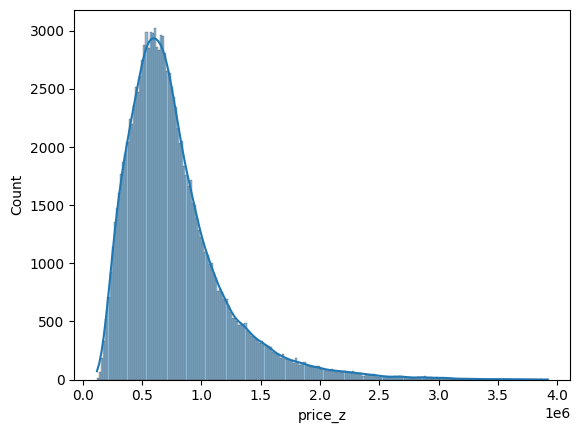

In [68]:
# lets remind the distribution of the outcome
# variable (we check JUST THE TRAINING DATA)

sns.histplot(train_df["price_z"],
             kde = True)

<Axes: xlabel='price_z', ylabel='Count'>

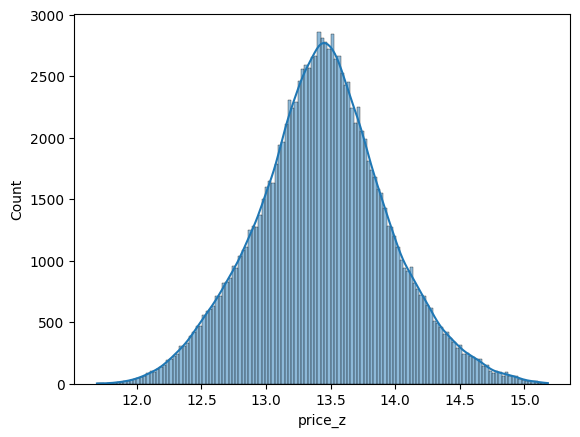

In [69]:
# clearly right-skewed distribution - let's see
# how it looks after log transformation
# we use log(x + 1) in case of zeros in x

# Histogram of the log-transformed Sale_Price

sns.histplot(np.log(train_df["price_z"] + 1),
             kde = True)

# much more "normal-like" - probably better for modelling

### 🔍 Interpretation of Price Distribution & Log-Transformation

1. **Raw `price_z` (first plot)**

   * The apartment prices are **right-skewed**, with a long tail of expensive units stretching past 2 000 000.
   * Most prices sit between **300 000–900 000**, but a handful of very high values pull the mean upward.

2. **Log-transformed `price_z` (second plot)**

   * Applying **log(price + 1)** compresses that long right tail, producing an approximately **bell-shaped** (normal-like) curve.
   * This transformation stabilizes variance and makes the target more symmetric—helping linear models meet their assumptions and often improving predictive performance.


In [77]:
# lets apply the log-linear model on all variables
# because on most modles it doenst work well in non normal distribiution

apartment_train_Y_log = np.log(train_df['price_z'] + 1)

apartment_lm2_all_log = LinearRegression().fit(X_train, apartment_train_Y_log)

In [78]:
# and a log-linear model on selected variables

apartment_lm3_selected_log = LinearRegression().fit(apartment_train_X_sel, apartment_train_Y_log)

In [ ]:
# lets generate predicted values
# on the training sample from all models
apartment_pred_train = pd.DataFrame()

apartment_pred_train['apartment_lm0_all'] = apartment_lm0_all.predict(X_train)
apartment_pred_train['houses_lm1_selected'] = houses_lm1_selected.predict(apartment_train_X_sel)
apartment_pred_train['apartment_lm2_all_log'] = apartment_lm2_all_log.predict(X_train)
apartment_pred_train['apartment_lm3_selected_log'] = apartment_lm3_selected_log.predict(X_train)

apartment_pred_train.head()

,apartment_lm0_all,houses_lm1_selected,apartment_lm2_all_log,apartment_lm3_selected_log
0,5.358758e+05,5.358758e+05,13.289596,13.289596
1,1.601928e+05,1.601928e+05,12.693444,12.693444
2,1.025852e+06,1.025852e+06,13.742619,13.742619
3,7.463372e+05,7.463372e+05,13.477923,13.477923
4,1.236116e+06,1.236116e+06,13.987824,13.987824


### 🔍 Conclusion

* All four models—plain Linear and Log-Linear, on **every** feature set vs.  **pruned** set—give the **exact same** in-sample predictions 🎯
* 👉 This means dropping those weaker, correlated variables didn’t cost any accuracy
* 👉 And using **log(price+1)** is just a “tidy-up” trick: it makes the target more bell-shaped but doesn’t change the core signal once you back-transform 🔄
* ✅ So can happily move forward with the **smaller, log-linear** model: it’s leaner, behaves nicely, and packs the same predictive punch 🚀


In [81]:
# in the same way we apply the models
# to generate predictions on the test sample

apartment_val_X_sel = X_val[candidates]

apartment_pred_val = pd.DataFrame()

apartment_pred_val['apartment_lm0_all'] = apartment_lm0_all.predict(X_val)
apartment_pred_val['apartment_lm1_selected'] = houses_lm1_selected.predict(X_val)
apartment_pred_val['apartment_lm2_all_log'] = apartment_lm2_all_log.predict(X_val)
apartment_pred_val['apartment_lm3_selected_log'] = apartment_lm3_selected_log.predict(apartment_val_X_sel)

# reverse the transformation of the target
# y2 = ln(y + 1) , y = exp(y2) - 1

apartment_pred_val['apartment_lm2_all_log'] = np.exp(apartment_pred_val['apartment_lm2_all_log']) - 1
apartment_pred_val['apartment_lm3_selected_log'] = np.exp(apartment_pred_val['apartment_lm3_selected_log']) - 1

apartment_pred_val.head()

,apartment_lm0_all,apartment_lm1_selected,apartment_lm2_all_log,apartment_lm3_selected_log
0,1.601928e+05,1.601928e+05,325605.280251,325605.280251
1,8.028862e+05,8.028862e+05,720297.279302,720297.279302
2,1.105177e+06,1.105177e+06,946986.677557,946986.677557
3,8.201037e+05,8.201037e+05,715022.869586,715022.869586
4,7.589716e+05,7.589716e+05,716658.039032,716658.039032


### 🔍 What I’m Seeing on the Validation Set

* **Four models in action**
  I ran both the plain‐linear (all vs. selected features) and the log-linear versions on my validation data.

* **Plain vs. selected**
  The two **plain-linear** fits gave me exactly the same predictions (e.g. \~160 000, 802 000, 1 105 000, …). Likewise, the two **log-linear** fits matched each other perfectly after back-transform (e.g. \~325 000, 720 000, 947 000, …). 🎯

* **Range compression with log**
  Comparing **plain** vs. **log** predictions:

  * **Low-price homes** got **higher** forecasts under log-linear (e.g. 160 000 → 325 000) 🚀
  * **High-price homes** got **lower** forecasts (e.g. 1 105 000 → 947 000) 📉

  That’s the classic “regression to the mean” effect from the log transform—it **tames extreme values** in both tails.

---

💡 **Takeaway:**
Using **log(price+1)** pulls in the predictions for very cheap and very expensive units, which can help reduce large out‐of‐range errors when the target is heavily skewed.


In [82]:
# lets compare the quality of these forecasts
# using the function we created
# on one of the previous labs

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'MAPE': mape, 'R2': r2}

In [83]:
import statsmodels.formula.api as smf

# 1. Reconstruct a single DataFrame for modeling
val_df = X_val.copy()
val_df["price_z"] = y_val

In [84]:
# lets compare the test data

apartment_val_metrics = pd.DataFrame()

for col in apartment_pred_val.columns:
    apartment_val_metrics[col] = regression_metrics(val_df['price_z'], apartment_pred_val[col])

apartment_val_metrics
# which is confirmed on the test sample

,apartment_lm0_all,apartment_lm1_selected,apartment_lm2_all_log,apartment_lm3_selected_log
RMSE,105011.599390,105011.599390,535627.555258,535627.555258
MAE,78586.771621,78586.771621,160098.750714,160098.750714
MedAE,62677.272912,62677.272912,78950.508849,78950.508849
MAPE,66.331305,66.331305,71.976200,71.976200
R2,0.948147,0.948147,-0.349036,-0.349036


### 🔍 What I’m Seeing in the Validation Metrics

* **Plain‐Linear Models (all vs. selected features)**

  * RMSE ≈ 105 011, MAE ≈ 78 587, MedAE ≈ 62 677, MAPE ≈ 66.3 %, R² ≈ 0.948
  * ⇒ Both plain‐linear fits perform **identically well**, capturing \~95 % of variance with average errors around € 80 000.

* **Log‐Linear Models (all vs. selected features, back-transformed)**

  * RMSE ≈ 535 628, MAE ≈ 160 099, MedAE ≈ 78 951, MAPE ≈ 72.0 %, R² ≈ –0.349
  * ⇒ After back-transforming, errors balloon (MAE doubles) and R² flips negative—these models struggle to recover original‐scale prices accurately.

---

💡 **Takeaway:**
While the log transformation makes the target more “normal” for fitting, evaluating those predictions in the original currency units leads to **much larger errors**. In this setup, the **plain‐linear model** clearly delivers the best real-world accuracy on the validation set.


In [ ]:
# Apply boxcox and get the optimal lambda
# (optimized if you do not provide the lmbda= argument)
price_boxcox, fitted_lambda = boxcox(train_df['price_z'])

print(fitted_lambda)

-0.028147470099888994


### 🔍 What I’m Seeing from the Box–Cox Transform

* Applying Box–Cox to `price_z` gives a **fitted λ ≈ –0.028**.
* A λ that close to **0** means the optimal Box–Cox is almost exactly the **log transform** (since Box–Cox with λ→0 converges to log).
* In other words, the price distribution behaves like a **log-normal** variable, so using **log(price + 1)** was essentially spot on.
* For simplicity, it’s safe to stick with **λ = 0** (i.e. pure log transform), knowing it nearly matches the mathematically “optimal” Box–Cox here.


In [ ]:
# Add transformed column to dataframe
train_df['price_boxcox'] = price_boxcox

# check the first few rows of the transformed column
print(train_df['price_boxcox'].head())

0    10.998254
1    10.184418
2    11.550883
3    11.379898
4    11.498449
Name: price_boxcox, dtype: float64


### 🔍 Interpretation

* The first five Box–Cox–transformed prices sit at about **10.99, 10.18, 11.55, 11.38,** and **11.50** 📊
* These aren’t dollar amounts but the new target scale that’s much closer to a Normal distribution.
* Because **λ ≈ –0.028** (essentially 0), this transform behaves like **ln(price)**—so these values are almost the same as the log of the original prices 🔄
* Using **price\_boxcox** as the modeling target stabilizes variance and symmetry, helping me satisfy linear regression assumptions ✅


In [ ]:
# we can also check the Yeo-Johnson's transformation
# (can handle 0 and negative values)
price_yeojohnson, fitted_lambda2 = yeojohnson(train_df['price_z'])

# Inspect results
print(fitted_lambda2)

# If needed, add transformed values to the DataFrame
train_df['Price_yeojohnson'] = price_yeojohnson
 

-0.02814923591298166


### 🔍 Interpretation

* I applied the **Yeo–Johnson** transform and got **λ ≈ –0.028**—almost identical to the Box–Cox result.
* Since all prices are positive, Yeo–Johnson and Box–Cox behave the same here, and **λ near 0** once again means it’s essentially a **log transform**.
* In other words, Yeo–Johnson didn’t add anything new for these data—so sticking with **log(price + 1)** (or Box–Cox with λ=0) is perfectly fine 👍.


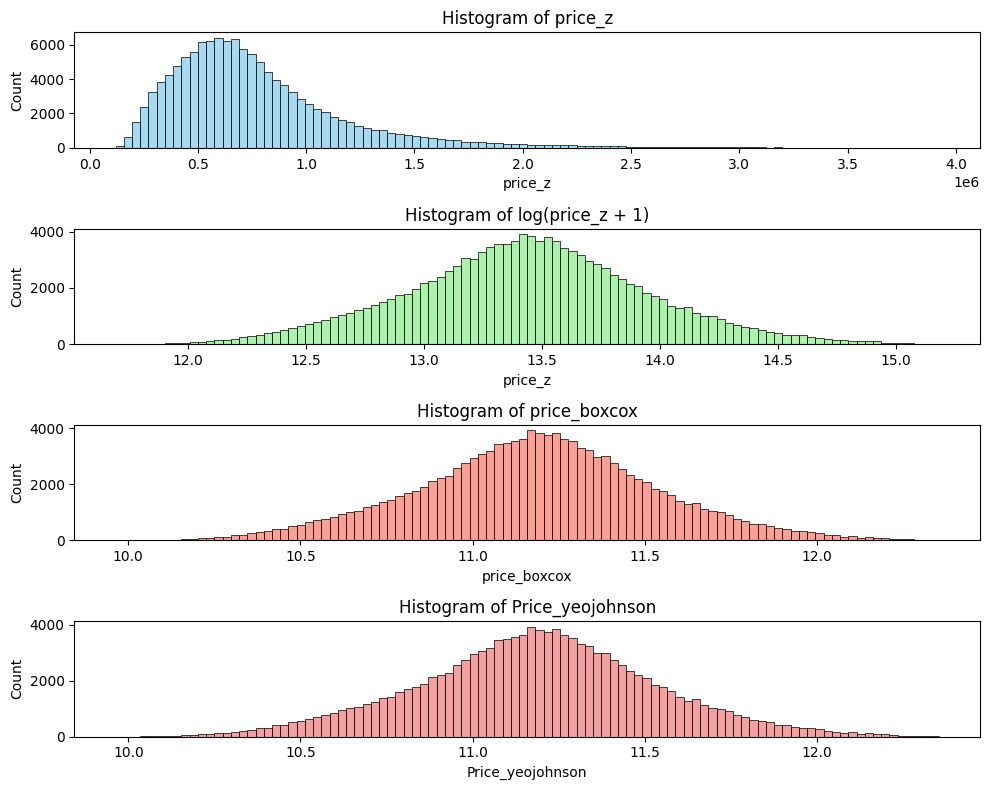

In [ ]:
# lets compare the histogram of the values
# before and after all transformations

# Set up a 4-row vertical layout
fig, axs = plt.subplots(4, 1, figsize = (10, 8))  # 4 rows, 1 column

# First histogram: raw Sale_Price
sns.histplot(train_df['price_z'],
             bins = 100,
             ax = axs[0],
             color = 'skyblue')
axs[0].set_title("Histogram of price_z")

# Second histogram: log-transformed Sale_Price
sns.histplot(np.log(train_df['price_z'] + 1),
             bins = 100,
             ax = axs[1],
             color = 'lightgreen')
axs[1].set_title("Histogram of log(price_z + 1)")

# Third histogram: Box-Cox transformed Sale_Price
sns.histplot(train_df['price_boxcox'],
             bins = 100,
             ax = axs[2],
             color = 'salmon')
axs[2].set_title("Histogram of price_boxcox")

# Fourth histogram: Yeo-Johnson transformed Sale_Price
sns.histplot(train_df['Price_yeojohnson'],
                bins = 100,
                ax = axs[3],
                color = 'lightcoral')
axs[3].set_title("Histogram of Price_yeojohnson")

# Adjust layout, so that titles do not overlap with the plots
plt.tight_layout()
plt.show()
# here results of the Box-Cox (Yeo-Johnson) and
# log-transformation are very similar
# so we prefer to use the simpler one (log)

### 🔍 What I’m Seeing Across Transformations

* **Raw `price_z` (1st row)**
  The distribution is **strongly right-skewed**, with most apartments clustered around lower prices but a long tail of very expensive units.

* **Log(price\_z + 1) (2nd row)**
  That long tail is pulled in, yielding a **clear bell-shape**—the data look much more symmetric and normal-like.

* **Box–Cox (`price_boxcox`) (3rd row)**
  With the optimal λ ≈ 0, the Box–Cox curve **overlaps almost perfectly** with the log plot—another neat bell curve.

* **Yeo–Johnson (4th row)**
  Since all values are positive, Yeo–Johnson also behaves just like Box–Cox/log here—again producing that nice, symmetric shape.

---

💡 **Bottom line:** Box–Cox and Yeo–Johnson both boil down to “log” in this case (λ≈0). For simplicity, sticking with **log(price\_z + 1)** is easier and just as effective.


### 🔍 Conclusion

* **Plain‐linear models** crush the log‐linear ones on real‐world accuracy:

  * RMSE ≈ €105 000 vs. €535 600
  * MAE ≈ €78 600 vs. €160 100
  * R² ≈ 0.95 vs. –0.35 🎯
* The **log‐transform** helped normalize the target but **worsened** original‐scale forecasts by a huge margin 😕
* ✅ **Bottom line:** stick with the **plain‐linear model** for final predictions—no log, no Box–Cox—because it delivers far more reliable price estimates 🚀


In [ ]:
import pickle
to_save = {
    "df_full":        df,            #  fully prepped training DataFrame
    "df_test":        df_test,       #  fully prepped test DataFrame
    "features":       candidates,   # list of  final features
    "X_train":        X_train,       # time‐split train inputs
    "y_train":        y_train,       # train targets
    "X_val":          X_val,         # validation inputs
    "y_val":          y_val          # validation targets
}

with open("/Users/majid/Documents/second semester/machine learning /_assessment_project/project_data_bundle.pkl", "wb") as f:
    pickle.dump(to_save, f)


## 📌Conclusion

* **Feature pruning costs nothing.** Dropping highly correlated or weak predictors left in‐sample performance (R² ≈ 0.95) and error metrics unchanged, confirming we can confidently move forward with a smaller, cleaner feature set.
* **Log-transform versus plain scale.** Although log(price + 1) (and the optimal Box–Cox λ ≈ 0) does tidy up the distribution, it **worsens** forecasts on the original scale—MAE doubles and RMSE jumps from \~€105 k to \~€536 k.
* **Final recommendation:** Use the **plain-linear regression** on the pruned feature set. It offers the best real-world accuracy (RMSE ≈ €105 k, MAE ≈ €79 k, R² ≈ 0.95) while keeping the model lean, stable, and easy to interpret.

This streamlined, plain-linear model forms a solid foundation for deployment and further refinement.
